In [1]:
!pip install arch
!pip install pmdarima
!pip install pandas_datareader
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import math as m
import random
import statsmodels.api as sm
import pandas_datareader as pdr
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import date
import datetime as dt
import pandas_datareader.data as web
import  plotly.express as px
from scipy.stats import norm
from arch import arch_model

## **Plot Data**

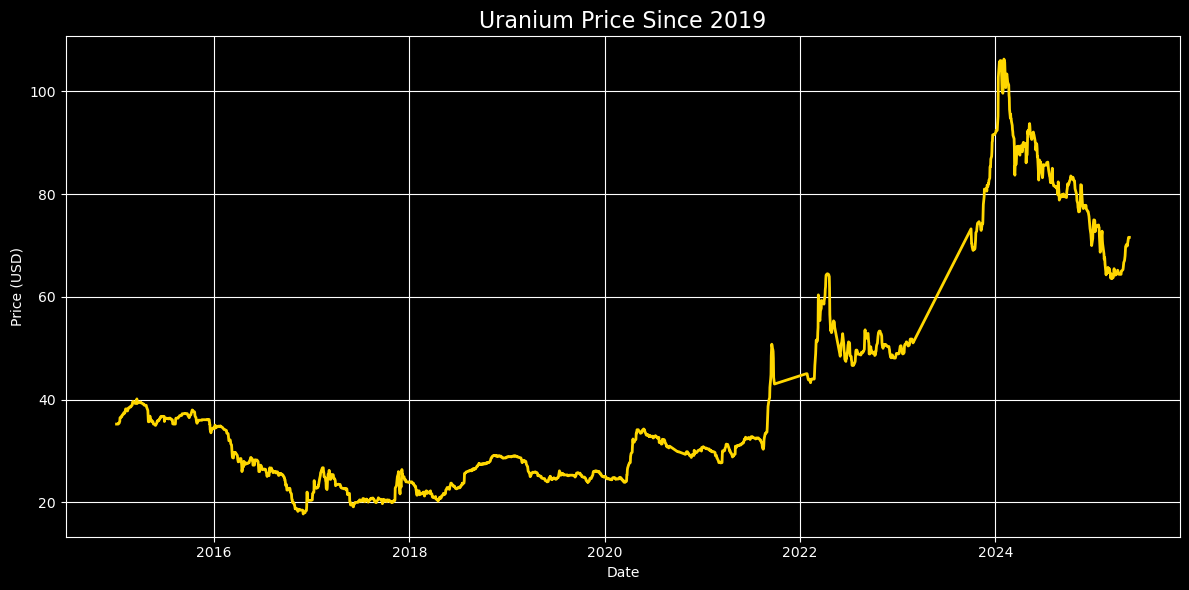

In [3]:

df = pd.read_csv("Uranium Futures Historical Data (3).csv")
df['Daily Return'] = df['Price'].pct_change().shift(-1).dropna()

# step 1: clean data


# convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'])


start_date = pd.to_datetime("2019-01-01")
end_date = pd.to_datetime("2025-05-29")


# sort by date in ascending order
df = df.set_index('Date')
df = df.rename(columns={'Price': 'Price'})

df['Returns'] = df['Price'].pct_change().shift(-1)
log_price = np.log(df['Price'] / df['Price'].shift(1))
log_price_cleaned = log_price.dropna()

# Step 5: Plot full data range
plt.style.use('dark_background')
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], color='gold', linewidth=2)
plt.title("Uranium Price Since 2019", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()



## **ADF test to test for stationarity, if it is not stationary we need to difference it to make it stationary and fit the ARIMA model**

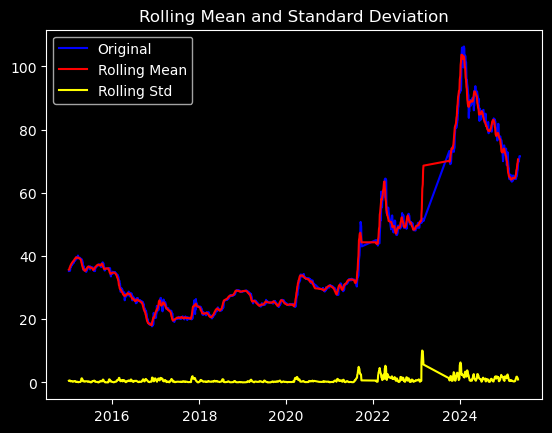

Results of ADF test
Test Statistics                  -1.475213
p-value                           0.545735
No. of lags used                 13.000000
Number of observations used    2323.000000
critical value (1%)              -3.433168
critical value (5%)              -2.862785
critical value (10%)             -2.567433
dtype: float64


In [5]:
#Test for staionarity code from https://github.com/WanjohiChristopher/Apple_Stock-Market-Forecasting-Time-Series-Analysis/blob/master/Apple_Stock-Market-Forecasting-Time-Series-Analysis.ipynb
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='yellow', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of ADF test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for adft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    return adft
    
adfr = test_stationarity(df['Price'])    

Fail to reject the null. T-stat is greater than the critical values therefore data is non-stationary. In order to make it fit the ARIMA model we need to make the data stationary by differencing. Graph is also showing the data is non-stationary

## **Differencing the Data, we can make non-stationary time-series stationary by taking the difference between observations. Differencing stabilizes our time-series by removing changes in the level of our time series, therefore reducing trends and seasonality.**

<Figure size 640x480 with 0 Axes>

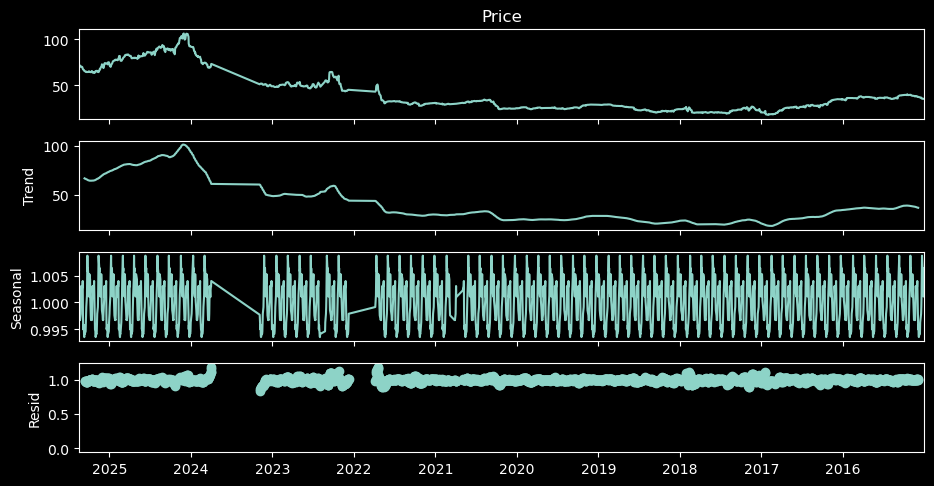

In [8]:
# Decompose the series to separate the trend and the seasonality from a time series, 
result = seasonal_decompose(df['Price'], model='multiplicative', period = 36)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 5)

#https://github.com/M3GHAN/stock-price-prediction-ARIMA-SARIMA/blob/main/stock-price-prediction.ipynb

seasonal_decompose function takes a non-stationary time series and breaks it down into trend, seasonality, residuals. This decomposition helps identify what non-stationary features are present so we can fit the data to ARIMA model.

* Price: shows strong trend and fluctuations indicating presence of seasonality/noise - not stationary
* Trend: shows a clear drop around 2023
* Seasonal: clearly shows a repeating pattern oscillating around 1.0 with some breaks in between which could be any kind of irregularity
* Residual: this plot shows whats left after removing trend and seasonality

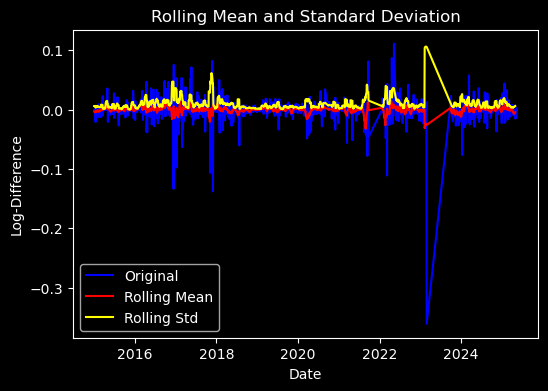

Test Statistic                -1.037039e+01
p-value                        2.272094e-18
Number of Lags Used            1.500000e+01
Number of Observations Used    2.320000e+03
Critical Value (1%)           -3.433172e+00
Critical Value (5%)           -2.862787e+00
Critical Value (10%)          -2.567434e+00
dtype: float64


In [10]:
#redo adf to check for stationarity  https://github.com/M3GHAN/stock-price-prediction-ARIMA-SARIMA/blob/main/stock-price-prediction.ipynb
def test_stationarity(timeseries):
    
    # Transformation to make the data stationary
    timeseries_log = np.log(timeseries)
    timeseries_log_diff = timeseries_log.diff().dropna()

    # Determing rolling statistics
    rolmean = timeseries_log_diff.rolling(window=12).mean()
    rolstd = timeseries_log_diff.rolling(window=12).std()

    # Plot rolling statistics
    plt.figure(figsize=(6, 4))
    plt.plot(timeseries_log_diff, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='yellow', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.xlabel('Date')
    plt.ylabel('Log-Difference')
    plt.show()

    # Perform ADF test
    adft = adfuller(timeseries_log_diff, autolag='AIC')

    # Output the ADF test results
    output = pd.Series(adft[0:4], index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key, value in adft[4].items():
        output[f'Critical Value ({key})'] = value
    print(output)

    return adft
    
adf_result = test_stationarity(df['Price'])

the rolling mean is nearly flat. the rolling standard deviation is relatively stable, with a few spikes, likely due to some irregularity or external shocks. the log-differenced series seems stationary visually.

the test statistic is also now much lower than all the critical values and the p-value<0.05 so we can now conclude the data is now stationary

In [12]:
model_auto = auto_arima(log_price_cleaned, #The input time series (in this case, log-transformed uranium prices) , start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,        # Starting seasonal AR term (not used here because seasonal=False)
                                        # Seasonal differencing order (not used here either)
                      D=0, 
                      trace=True,       # Print the progress and show the models being tested
                      error_action='ignore', # Ignore errors when trying different model combinations 
                      suppress_warnings=True,  # Suppress convergence warnings and other statistical warnings
                      ) 
print(model_auto.summary())

#https://github.com/WanjohiChristopher/Apple_Stock-Market-Forecasting-Time-Series-Analysis/blob/master/Apple_Stock-Market-Forecasting-Time-Series-Analysis.ipynb

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-13026.713, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-12983.838, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-13024.804, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-13023.785, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-13020.511, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-13020.834, Time=0.22 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-13023.804, Time=0.47 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-13027.075, Time=0.49 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-13018.732, Time=0.36 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-13023.107, Time=0.34 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-13018.412, Time=0.39 sec

Best model:  ARIMA(2,0,3)(0,0,0)[0]          
Total fit time: 2.921 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observati

* AR(1)  0.05 < 0.565 Not significant 
* AR(2)  0.05 > 0.001 Significant 
* MA(1)  0.05 < 0.788 Not significant 
* MA(2)  0.05 > 0.008 Significant 
* MA(3)  0.05 > 0.020 Significant

AR(2) being significant indicates that the time series is influenced by the value two steps ago. MA(2) and MA(3) being significant means the model is using noise patterns from 2 and 3 periods back to better explain the current value

in simple terms: today’s price is shaped mostly by what the price was two days ago and by surprises that happened two and three days ago (since our data is daily)

In [23]:
#https://github.com/NdAbdulsalaam/bitcon-prediction-arima-garch-models

model = arch_model(log_price_cleaned, vol='GARCH', p=1, q=1, rescale = False)
garch_fit = model.fit()
garch_fit.summary()


Iteration:      1,   Func. Count:      6,   Neg. LLF: 709658113035.0526
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4025615457638.193
Iteration:      3,   Func. Count:     34,   Neg. LLF: 56488710723.952614
Iteration:      4,   Func. Count:     48,   Neg. LLF: -6974.615350092642
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6974.615353606536
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6974.62
Distribution:                  Normal   AIC:                          -13941.2
Method:            Maximum Likelihood   BIC:                          -13918.2
                                        No. Observations:                 2336
Date:                Mon, Jul 07 2025   Df Residuals:                     2335
Time:                        23:09:59   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -6.2052e-04  7.798e-04     -0.796      0.426 [-2.149e-03,9.079e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.2548e-05  3.247e-12  6.943e+06      0.000 [2.255e-05,2.255e-05]
alpha[1]       0.2000  8.909e-02      2.245  2.477e-02   [2.539e-02,  0.375]
beta[1]        0.7000  3.740e-02     18.716  3.682e-78     [  0.627,  0.773]
============================================================================

Covariance estimator: robust
"""

## **monte carlo simulation**

In [ ]:
mean = log_price.mean() # finding mean of daily log returns
var = log_price.var() # finding variance of daily log returns
stdev = log_price.std() # finding standard deviation of daily log returns
drift = mean - (0.5 * var)
print(drift) # can be interpreted as expected daily return
print (mean)
print (var)

In [ ]:
# Example (explanation) for the next cell of code:

norm.ppf(0.95) # will give us apprx. how much standard deviations away from the mean is an event with 95% probability of occuring (1.65 st.d. away from the mean e.g) 
x = np.random.rand(10,2) # will give 10 by 2 matrix with random (0;1] numbers (probabilities)
norm.ppf(x) # will give distances from the mean (st.deviations) accordingly to the previous matrix

In [ ]:

t_intervals = 182 # stock price forecast for upcoming 6 months 
iterations = 50
# 1000 different predictions
#daily_returns = np.exp(np.random.normal(mu, sigma, (t_intervals, iterations)))
daily_returns = np.exp(np.array(drift) + np.array(stdev) * norm.ppf(np.random.rand(t_intervals, iterations))) # np.exp calculates e^(expression) - expression is r = drift + stdev*Z(random variable)
# This will give us ten arrays of 1000 random future stock returns (10 columns, 1000 rows)
daily_returns

In [ ]:
# To create a stock price list:


S0 = df['Price'].iloc[0]                   # last price of Uranium in the data, which is a starting point for future prices
price_list  = np.zeros_like(daily_returns) # creates 1000*10 array full of zeros (empty array), we will fill it with the prices according to S0 and 10 set of random daily returns
price_list[0] = S0                         # all the first rows of 10 columns will be set as the last price of Uranium
future_dates = pd.date_range(start=end_date, periods=t_intervals)
for t in range(1, t_intervals):
       price_list[t] = price_list[t-1] * daily_returns[t] # the arrays will be filled with 10 random Uranium prices for the next 1000 days

plt.figure(figsize = (10,6))
plt.plot(price_list)
plt.ylim(30,100)
plt.title("50 Different Uranium Future Price Simulation")
plt.xlabel("Day")
plt.ylabel("Price")
plt.grid(True)

mean_prices = np.mean(price_list, axis=1)            #average of prices in price list
x = np.arange(t_intervals)                           #independent variable x which is the number of days
coefficients = np.polyfit(x, mean_prices, 1)         #performing OLS using x and mean prices to calculate slope and y intercept of the line
function = np.poly1d(coefficients)                   #creating a function for x and y
line_of_best_fit = function(x)                       #creating line based on the function 
plt.plot(line_of_best_fit, color='red', linewidth=2, label='Line of Best Fit (Mean)')




## **european call**

In [ ]:
#https://github.com/kushalgowdagv/Pricing_Models/blob/main/streamlit_app.py

S = df['Price'].iloc[0] # current price of the uranium
K = 70                  # strike price of the call option
T = 0.5                 # time to maturity in years  
r = 0.035               # risk-free interest rate 
num_simulations = 10000

daily_vol = log_price.std()            #calculation of daily volatility
annual_vol = daily_vol * np.sqrt(252)  # assuming 252 trading days
sigma = annual_vol                     # annualized volatility of the underlying

def monte_carlo_european_call(S, K, T, r, sigma, num_simulations=10000):
    Z = np.random.standard_normal(num_simulations)                     #generates random numbers from the standard normal dist. these are random shocks for simulating asset prices under geometric brownian motion
    ST = S * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z) #simulates future price of uranium at time T
    payoffs = np.maximum(ST - K, 0)                                    # call option payoff, european call option only pays off at expiration and if underlying price is above strike
    call_price = np.exp(-r * T) * np.mean(payoffs)                     # taking average of all payoffs and discounts it to pv to give fair value of ECP 
    return round(call_price, 2)


In [ ]:
call_price = monte_carlo_european_call(S, K, T, r, sigma)
print("European Call Option Price:")
print(call_price)

plt.figure(figsize=(12, 6))
for i in range(50):  # Plot 10 random paths
    plt.plot(price_list[:, i], lw=1)

plt.title("Simulated Asset Price Paths (Monte Carlo)")
plt.xlabel("Time (Days)")
plt.ylabel("Price")
plt.grid("true")
plt.show()

#Simulates many possible future prices of Uranium at the option's expiration date

# **references**
### https://github.com/ds-brx/Time-series-analysis-project/blob/main/lstm-rnn-arimax-ar-models-and-analysis.ipynb
### https://github.com/vishnukanduri/Time-series-analysis-in-Python/blob/master/11.%20Auto%20ARIMA.ipynb
### https://github.com/M3GHAN/stock-price-prediction-ARIMA-SARIMA/blob/main/stock-price-prediction.ipynb
### https://github.com/WanjohiChristopher/Apple_Stock-Market-Forecasting-Time-Series-Analysis/blob/master/Apple_Stock-Market-Forecasting-Time-Series-Analysis.ipynb
### https://github.com/kushalgowdagv/Pricing_Models/blob/main/streamlit_app.py
### https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
### https://numpy.org/doc/stable/reference/generated/numpy.poly1d.html
### https://github.com/NdAbdulsalaam/bitcon-prediction-arima-garch-models